<div style="text-align:center">
    <h1>
        Deep Q-Learning
    </h1>
</div>

<br><br>

<div style="text-align:center">

In this notebook, we extend the Q-Learning algorithm to use function approximators (Neural Networks). The resulting algorithm is known as Deep Q-Learning.
</div>



<br>

In [3]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



#!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
import torch
from matplotlib import animation
import matplotlib.patches as mpatches

from IPython.display import HTML

import gymnasium as gym
from gymnasium import spaces
from gymnasium.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, _, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)


def seed_everything(env: gym.Env, seed: int = 42) -> None:
    #env.seed(seed)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


def plot_cost_to_go(env, q_network, xlabel=None, ylabel=None):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)

    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = - q_network(q_net_input).max(dim=-1, keepdim=True)[0]
    Z = Z.reshape(100, 100).detach().numpy()
    X = X.numpy()
    Y = Y.numpy()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(xlabel, size=14)
    ax.set_ylabel(ylabel, size=14)
    ax.set_title("Estimated cost-to-go", size=18)
    plt.tight_layout()
    plt.show()


def plot_max_q(env, q_network, xlabel=None, ylabel=None, action_labels=[]):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)
    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = q_network(q_net_input).argmax(dim=-1, keepdim=True)
    Z = Z.reshape(100, 100).T.detach().numpy()
    values = np.unique(Z.ravel())
    values.sort()

    plt.figure(figsize=(5, 5))
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    plt.title("Optimal action", size=18)

    im = plt.imshow(Z, cmap='jet')
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, action_labels)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()



<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


## Import the necessary software libraries:

In [4]:
import random
import copy
import gymnasium  as gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

## Create and prepare the environment

### Create the environment

/home/gpaik/.conda/envs/pytorch/lib/python3.12/site-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


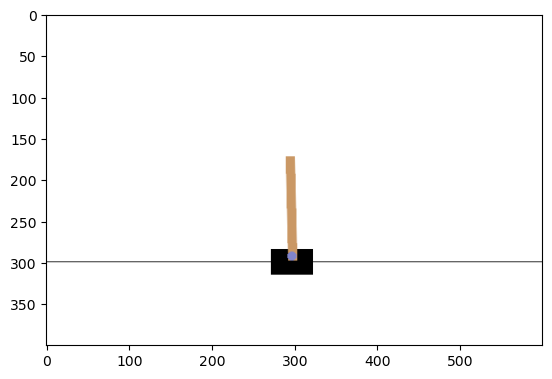

In [5]:
env = gym.make('CartPole-v0', render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

### Prepare the environment to work with PyTorch

In [ ]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self):
        obs = self.env.reset()
        return torch.from_numpy(obs).unsqueeze(dim=0).float()

    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [ ]:
env = PreprocessEnv(env)

In [ ]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

## Create the Q-Network and policy

<br><br>

### Create the Q-Network: $\hat q(s,a| \theta)$

### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

### Create the exploratory policy: $b(s)$

In [ ]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

## Create the Experience Replay buffer

<br>
<div style="text-align:center">
    <p>A simple buffer that stores transitions of arbitrary values, adapted from
    <a href="https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training">this source.</a></p>
</div>


In [ ]:
class ReplayMemory:

    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

## Implement the algorithm

</br></br>

## Show results

### Plot execution stats

In [ ]:
plot_stats(stats)

### Test the resulting agent

In [ ]:
test_agent(env, policy, episodes=2)

## Resources

[[1] Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)